# Forest Fire Prediction Project - Unsupervised Learning (Clustering)

**Project**: Predicting Forest Fires using Soil and Climate Data  
**Study Area**: Algeria & Tunisia  
**Year**: 2024  

This notebook implements unsupervised learning techniques:
1. K-Means Clustering
2. CLARA (K-Medoids for large datasets)
3. DBSCAN (Density-based clustering)

Each method includes:
- Implementation and optimization
- Comprehensive evaluation metrics
- PCA visualization
- Geographic visualization
- Comparative analysis


In [1]:
## 0. Import Libraries and Setup



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from time import time

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample

# Clustering algorithms
from sklearn.cluster import KMeans, DBSCAN
from sklearn_extra.cluster import KMedoids

# Evaluation metrics
from sklearn.metrics import (
    silhouette_score, 
    davies_bouldin_score, 
    calinski_harabasz_score,
    silhouette_samples
)

# Suppress warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)

print(f"NumPy version: {np.__version__}")


NumPy version: 1.26.4


## 1. Load and Prepare Data

In [2]:
def load_clustering_data(filepath):
    """
    Load data for clustering analysis.
    
    Parameters:
    -----------
    filepath : str
        Path to cleaned dataset
    
    Returns:
    --------
    df : DataFrame
        Original dataframe
    X : array
        Feature matrix
    coords : array or None
        Geographic coordinates if available
    feature_names : list
        Feature column names
    """
    
    print("="*70)
    print("LOADING DATA FOR CLUSTERING")
    print("="*70)
    
    df = pd.read_csv(filepath)
    
    print(f"Dataset shape: {df.shape}")
    print(f"Total samples: {len(df):,}")
    
    # Identify geographic columns
    lat_col = None
    lon_col = None
    for col in df.columns:
        if 'latitude' in col.lower():
            lat_col = col
        if 'longitude' in col.lower():
            lon_col = col
    
    if lat_col and lon_col:
        print(f" Geographic columns found: {lat_col}, {lon_col}")
        coords = df[[lat_col, lon_col]].values
    else:
        print("  No geographic coordinates found")
        coords = None
    
    # Prepare feature matrix (exclude target and coordinates)
    exclude_cols = ["fire"]
    if lat_col:
        exclude_cols.append(lat_col)
    if lon_col:
        exclude_cols.append(lon_col)
    
    feature_names = [col for col in df.columns if col not in exclude_cols]
    X = df[feature_names].values
    
    print(f"\nFeature matrix shape: {X.shape}")
    print(f"Number of features: {len(feature_names)}")
    
    # Check for target distribution
    if 'fire' in df.columns:
        print(f"\nTarget distribution:")
        print(df['fire'].value_counts())
    
    print("="*70)
    
    return df, X, coords, feature_names

# Load data
df, X, coords, feature_names = load_clustering_data("../data/processed/Fire/final.csv")


LOADING DATA FOR CLUSTERING
Dataset shape: (104372, 18)
Total samples: 104,372
 Geographic columns found: latitude, longitude

Feature matrix shape: (104372, 15)
Number of features: 15

Target distribution:
fire
0    90156
1    14216
Name: count, dtype: int64


## 2. Data Preprocessing

In [3]:
## 2.1 Feature Scaling
def scale_features(X):
    """
    Scale features using MinMaxScaler.
    
    Parameters:
    -----------
    X : array
        Feature matrix
    
    Returns:
    --------
    X_scaled : array
        Scaled features
    scaler : MinMaxScaler
        Fitted scaler
    """
    
    print("="*70)
    print("FEATURE SCALING")
    print("="*70)
    
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    print("Scaler: MinMaxScaler (range [0, 1])")
    print(f"\nScaled data statistics:")
    print(f"  Min: {X_scaled.min():.4f}")
    print(f"  Max: {X_scaled.max():.4f}")
    print(f"  Mean: {X_scaled.mean():.4f}")
    print(f"  Std: {X_scaled.std():.4f}")
    
    print("\n Feature scaling complete")
    print("="*70)
    
    return X_scaled, scaler

# Scale features
X_scaled, scaler = scale_features(X)


FEATURE SCALING
Scaler: MinMaxScaler (range [0, 1])

Scaled data statistics:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.4513
  Std: 0.3311

 Feature scaling complete


DIMENSIONALITY REDUCTION (PCA)
Reducing to 2 components for visualization...

 PCA Results:
  Explained variance ratio: [0.48737422 0.21122944]
  Total variance explained: 0.6986 (69.86%)


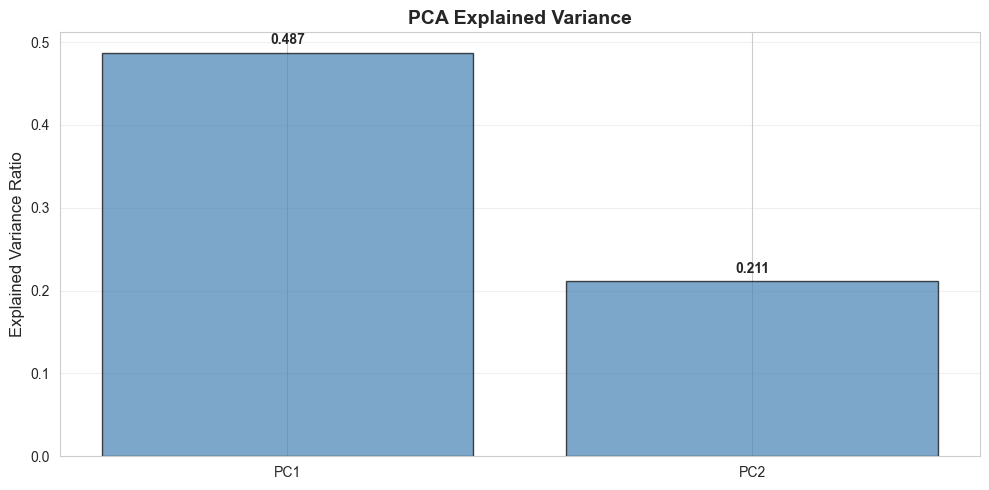


 PCA transformation complete


In [4]:
## 2.2 Dimensionality Reduction (PCA for Visualization)
def apply_pca(X_scaled, n_components=2):
    """
    Apply PCA for visualization.
    
    Parameters:
    -----------
    X_scaled : array
        Scaled features
    n_components : int
        Number of principal components
    
    Returns:
    --------
    X_pca : array
        PCA-transformed data
    pca : PCA
        Fitted PCA object
    """
    
    print("="*70)
    print("DIMENSIONALITY REDUCTION (PCA)")
    print("="*70)
    
    print(f"Reducing to {n_components} components for visualization...")
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"\n PCA Results:")
    print(f"  Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"  Total variance explained: {sum(pca.explained_variance_ratio_):.4f} ({sum(pca.explained_variance_ratio_)*100:.2f}%)")
    
    # Visualize explained variance
    plt.figure(figsize=(10, 5))
    plt.bar(['PC1', 'PC2'], pca.explained_variance_ratio_, 
           color='steelblue', edgecolor='black', alpha=0.7)
    plt.ylabel('Explained Variance Ratio', fontsize=12)
    plt.title('PCA Explained Variance', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    for i, val in enumerate(pca.explained_variance_ratio_):
        plt.text(i, val + 0.01, f'{val:.3f}', ha='center', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n PCA transformation complete")
    print("="*70)
    
    return X_pca, pca

# Apply PCA
X_pca, pca = apply_pca(X_scaled)


## 3. Clustering Evaluation Framework

In [5]:
def evaluate_clustering(X, labels, method_name):
    """
    Comprehensive clustering evaluation.
    
    Parameters:
    -----------
    X : array
        Feature matrix
    labels : array
        Cluster labels
    method_name : str
        Name of clustering method
    
    Returns:
    --------
    metrics : dict
        Dictionary of evaluation metrics
    """
    
    print(f"\n{'='*70}")
    print(f"{method_name.upper()} - EVALUATION")
    print(f"{'='*70}")
    
    # Count clusters
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    n_noise = list(labels).count(-1) if -1 in labels else 0
    
    print(f"\n Cluster Statistics:")
    print(f"  Number of clusters: {n_clusters}")
    print(f"  Noise points: {n_noise} ({n_noise/len(labels)*100:.2f}%)")
    
    # Cluster distribution
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n Cluster Distribution:")
    for cluster_id, count in zip(unique, counts):
        label = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
        print(f"  {label}: {count:,} ({count/len(labels)*100:.2f}%)")
    
    # Visualize cluster sizes
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(unique)))
    bars = ax.bar([f'C{i}' if i != -1 else 'Noise' for i in unique], counts, 
                  color=colors, edgecolor='black', alpha=0.7)
    ax.set_ylabel('Number of Points', fontsize=12)
    ax.set_title(f'Cluster Size Distribution: {method_name}', 
                fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Compute quality metrics (excluding noise)
    valid_mask = labels != -1
    X_valid = X[valid_mask]
    labels_valid = labels[valid_mask]
    
    metrics = {
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_percentage': n_noise/len(labels)*100
    }
    
    if len(set(labels_valid)) > 1 and len(labels_valid) > 0:
        print(f"\n Quality Metrics:")
        
        # Silhouette Score
        sil_score = silhouette_score(X_valid, labels_valid)
        metrics['silhouette'] = sil_score
        print(f"  Silhouette Score: {sil_score:.4f}")
        print(f"    → Range: [-1, 1], Higher is better")
        print(f"    → Interpretation: {interpret_silhouette(sil_score)}")
        
        # Davies-Bouldin Score
        db_score = davies_bouldin_score(X_valid, labels_valid)
        metrics['davies_bouldin'] = db_score
        print(f"\n  Davies-Bouldin Score: {db_score:.4f}")
        print(f"    → Lower is better (minimum: 0)")
        print(f"    → Interpretation: {interpret_davies_bouldin(db_score)}")
        
        # Calinski-Harabasz Score
        ch_score = calinski_harabasz_score(X_valid, labels_valid)
        metrics['calinski_harabasz'] = ch_score
        print(f"\n  Calinski-Harabasz Score: {ch_score:.2f}")
        print(f"    → Higher is better")
        print(f"    → Interpretation: {interpret_calinski(ch_score)}")
        
    else:
        print("\n  Cannot compute quality metrics: insufficient clusters")
        metrics.update({
            'silhouette': None,
            'davies_bouldin': None,
            'calinski_harabasz': None
        })
    
    print("="*70)
    
    return metrics

def interpret_silhouette(score):
    """Interpret silhouette score."""
    if score > 0.7:
        return "Excellent separation"
    elif score > 0.5:
        return "Good separation"
    elif score > 0.25:
        return "Weak separation"
    else:
        return "Poor separation"

def interpret_davies_bouldin(score):
    """Interpret Davies-Bouldin score."""
    if score < 0.5:
        return "Excellent clustering"
    elif score < 1.0:
        return "Good clustering"
    elif score < 2.0:
        return "Fair clustering"
    else:
        return "Poor clustering"

def interpret_calinski(score):
    """Interpret Calinski-Harabasz score."""
    if score > 1000:
        return "Excellent clustering"
    elif score > 500:
        return "Good clustering"
    elif score > 100:
        return "Fair clustering"
    else:
        return "Poor clustering"

## 4. K-Means Clustering

In [6]:
print("\n" + "="*70)
print("METHOD 1: K-MEANS CLUSTERING")
print("="*70)

## 4.1 Elbow Method for Optimal K

def find_optimal_k_elbow(X_scaled, k_range=range(2, 11)):
    """
    Find optimal K using elbow method.
    
    Parameters:
    -----------
    X_scaled : array
        Scaled features
    k_range : range
        Range of K values to test
    
    Returns:
    --------
    inertias : list
        Inertia values for each K
    """
    
    print("\n Finding Optimal K (Elbow Method)...")
    
    inertias = []
    silhouette_scores = []
    
    for k in k_range:
        print(f"  Testing k={k}...", end=' ')
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
        
        if k > 1:
            sil_score = silhouette_score(X_scaled, kmeans.labels_)
            silhouette_scores.append(sil_score)
            print(f"Inertia: {kmeans.inertia_:.2f}, Silhouette: {sil_score:.4f}")
        else:
            silhouette_scores.append(0)
            print(f"Inertia: {kmeans.inertia_:.2f}")
    
    # Plot elbow curve
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Inertia plot
    axes[0].plot(list(k_range), inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
    axes[0].set_ylabel('Inertia (Within-cluster Sum of Squares)', fontsize=12)
    axes[0].set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Silhouette plot
    axes[1].plot(list(k_range)[1:], silhouette_scores[1:], 'ro-', linewidth=2, markersize=8)
    axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
    axes[1].set_ylabel('Silhouette Score', fontsize=12)
    axes[1].set_title('Silhouette Score vs K', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0.5, color='green', linestyle='--', label='Good threshold (0.5)')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return inertias, silhouette_scores

# Find optimal K
#inertias, silhouette_scores = find_optimal_k_elbow(X_scaled, k_range=range(2, 11))



METHOD 1: K-MEANS CLUSTERING



 Training K-Means (k=4)...
 K-Means training complete in 0.76 seconds
   Final inertia: 14414.00
   Iterations: 16

K-MEANS - EVALUATION

 Cluster Statistics:
  Number of clusters: 4
  Noise points: 0 (0.00%)

 Cluster Distribution:
  Cluster 0: 40,502 (38.81%)
  Cluster 1: 27,175 (26.04%)
  Cluster 2: 12,125 (11.62%)
  Cluster 3: 24,570 (23.54%)


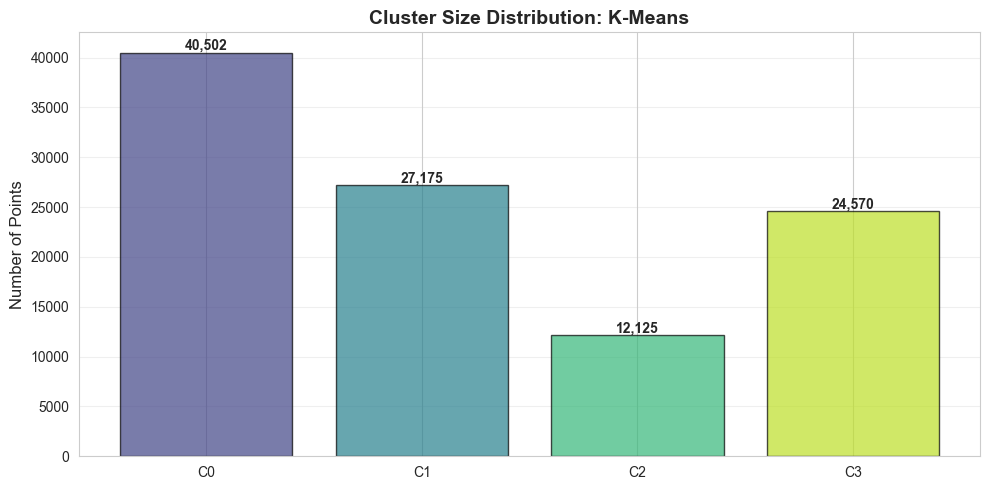


 Quality Metrics:
  Silhouette Score: 0.3331
    → Range: [-1, 1], Higher is better
    → Interpretation: Weak separation

  Davies-Bouldin Score: 1.2731
    → Lower is better (minimum: 0)
    → Interpretation: Fair clustering

  Calinski-Harabasz Score: 60167.07
    → Higher is better
    → Interpretation: Excellent clustering


In [7]:

## 4.2 K-Means with Optimal K
def train_kmeans(X_scaled, k=4):
    """
    Train K-Means clustering.
    
    Parameters:
    -----------
    X_scaled : array
        Scaled features
    k : int
        Number of clusters
    
    Returns:
    --------
    kmeans : KMeans
        Fitted K-Means model
    labels : array
        Cluster labels
    """
    
    print(f"\n Training K-Means (k={k})...")
    
    start_time = time()
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_scaled)
    train_time = time() - start_time
    
    print(f" K-Means training complete in {train_time:.2f} seconds")
    print(f"   Final inertia: {kmeans.inertia_:.2f}")
    print(f"   Iterations: {kmeans.n_iter_}")
    
    return kmeans, labels

# Train K-Means
k_optimal = 4
kmeans_model, kmeans_labels = train_kmeans(X_scaled, k=k_optimal)

# Evaluate K-Means
kmeans_metrics = evaluate_clustering(X_scaled, kmeans_labels, "K-Means")


## 5. CLARA (K-Medoids for Large Datasets)



METHOD 2: CLARA (K-MEDOIDS)

 Training CLARA (k=4)...
   Sample size: 10,000
   Total data size: 104,372
   Step 1: Creating sample...
   Step 2: Finding medoids on sample...
   Step 3: Assigning all points to medoids...
 CLARA training complete in 50.29 seconds
   Fit time: 50.25s
   Prediction time: 0.04s

CLARA - EVALUATION

 Cluster Statistics:
  Number of clusters: 4
  Noise points: 0 (0.00%)

 Cluster Distribution:
  Cluster 0: 25,498 (24.43%)
  Cluster 1: 20,612 (19.75%)
  Cluster 2: 47,833 (45.83%)
  Cluster 3: 10,429 (9.99%)


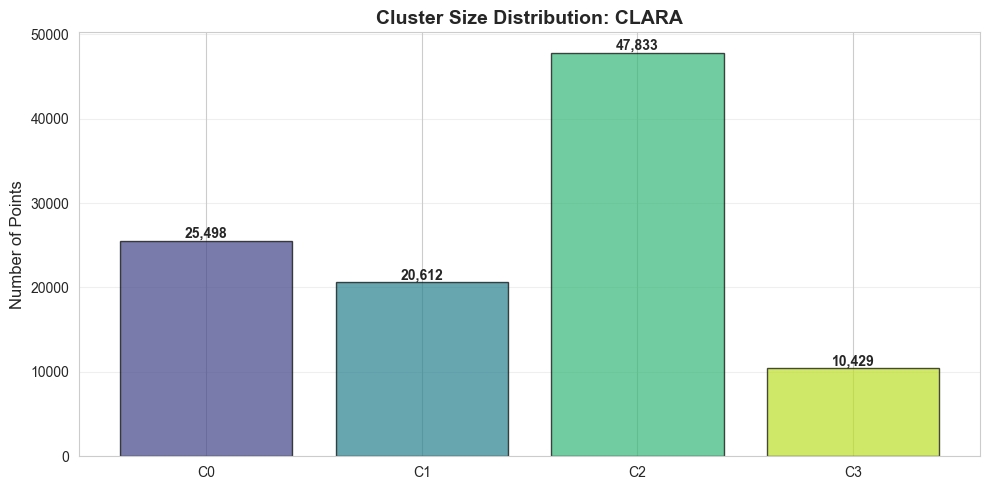


 Quality Metrics:
  Silhouette Score: 0.3268
    → Range: [-1, 1], Higher is better
    → Interpretation: Weak separation

  Davies-Bouldin Score: 1.2667
    → Lower is better (minimum: 0)
    → Interpretation: Fair clustering

  Calinski-Harabasz Score: 57272.66
    → Higher is better
    → Interpretation: Excellent clustering


In [8]:
print("\n" + "="*70)
print("METHOD 2: CLARA (K-MEDOIDS)")
print("="*70)

## 5.1 CLARA Implementation
def train_clara(X_scaled, k=4, sample_size=10000):
    """
    Train CLARA (Clustering Large Applications).
    Uses sampling approach for large datasets.
    
    Parameters:
    -----------
    X_scaled : array
        Scaled features
    k : int
        Number of clusters
    sample_size : int
        Size of sample for medoid finding
    
    Returns:
    --------
    clara : KMedoids
        Fitted CLARA model
    labels : array
        Cluster labels for all data
    """
    
    print(f"\n Training CLARA (k={k})...")
    print(f"   Sample size: {sample_size:,}")
    print(f"   Total data size: {len(X_scaled):,}")
    
    # Step 1: Sample data
    print("   Step 1: Creating sample...")
    X_sample = resample(X_scaled, n_samples=sample_size, replace=False, random_state=42)
    
    # Step 2: Find medoids on sample
    print("   Step 2: Finding medoids on sample...")
    start_time = time()
    clara = KMedoids(n_clusters=k, method='pam', init='k-medoids++', random_state=42)
    clara.fit(X_sample)
    fit_time = time() - start_time
    
    # Step 3: Assign all points to medoids
    print("   Step 3: Assigning all points to medoids...")
    predict_start = time()
    labels = clara.predict(X_scaled)
    predict_time = time() - predict_start
    
    total_time = fit_time + predict_time
    
    print(f" CLARA training complete in {total_time:.2f} seconds")
    print(f"   Fit time: {fit_time:.2f}s")
    print(f"   Prediction time: {predict_time:.2f}s")
    
    return clara, labels

# Train CLARA
k_clara = 4
clara_model, clara_labels = train_clara(X_scaled, k=k_clara, sample_size=10000)

# Evaluate CLARA
clara_metrics = evaluate_clustering(X_scaled, clara_labels, "CLARA")


## 6. DBSCAN (Density-Based Clustering)

In [9]:
print("\n" + "="*70)
print("METHOD 3: DBSCAN")
print("="*70)

## 6.1 Parameter Selection for DBSCAN

def find_dbscan_eps(X_scaled, k=4, sample_size=5000):
    """
    Find optimal eps parameter using k-distance plot.
    
    Parameters:
    -----------
    X_scaled : array
        Scaled features
    k : int
        Number of neighbors (min_samples)
    sample_size : int
        Sample size for faster computation
    
    Returns:
    --------
    suggested_eps : float
        Suggested eps value
    """
    
    from sklearn.neighbors import NearestNeighbors
    
    print(f"\n Finding optimal eps (using {sample_size:,} samples)...")
    
    # Sample data for faster computation
    X_sample = resample(X_scaled, n_samples=min(sample_size, len(X_scaled)), 
                       replace=False, random_state=42)
    
    # Compute k-distances
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors.fit(X_sample)
    distances, indices = neighbors.kneighbors(X_sample)
    
    # Sort distances
    distances = np.sort(distances[:, k-1], axis=0)
    
    # Plot k-distance graph
    plt.figure(figsize=(10, 6))
    plt.plot(distances, linewidth=2)
    plt.ylabel(f'{k}-NN Distance', fontsize=12)
    plt.xlabel('Points sorted by distance', fontsize=12)
    plt.title(f'K-Distance Graph (k={k})', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Suggest eps as the "elbow" (e.g., 90th percentile)
    suggested_eps = np.percentile(distances, 90)
    plt.axhline(y=suggested_eps, color='r', linestyle='--', 
               label=f'Suggested eps={suggested_eps:.3f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f" Suggested eps: {suggested_eps:.3f}")
    
    return suggested_eps

# Find optimal eps
#suggested_eps = find_dbscan_eps(X_scaled, k=10, sample_size=5000)



METHOD 3: DBSCAN



 Training DBSCAN...
   eps: 0.15
   min_samples: 10
 DBSCAN training complete in 33.31 seconds

DBSCAN - EVALUATION

 Cluster Statistics:
  Number of clusters: 146
  Noise points: 1245 (1.19%)

 Cluster Distribution:
  Noise: 1,245 (1.19%)
  Cluster 0: 6,615 (6.34%)
  Cluster 1: 13,706 (13.13%)
  Cluster 2: 24,871 (23.83%)
  Cluster 3: 15,822 (15.16%)
  Cluster 4: 9,113 (8.73%)
  Cluster 5: 1,813 (1.74%)
  Cluster 6: 46 (0.04%)
  Cluster 7: 1,748 (1.67%)
  Cluster 8: 4,165 (3.99%)
  Cluster 9: 17 (0.02%)
  Cluster 10: 1,119 (1.07%)
  Cluster 11: 4,702 (4.51%)
  Cluster 12: 47 (0.05%)
  Cluster 13: 1,386 (1.33%)
  Cluster 14: 20 (0.02%)
  Cluster 15: 65 (0.06%)
  Cluster 16: 12 (0.01%)
  Cluster 17: 1,361 (1.30%)
  Cluster 18: 31 (0.03%)
  Cluster 19: 374 (0.36%)
  Cluster 20: 1,238 (1.19%)
  Cluster 21: 242 (0.23%)
  Cluster 22: 11 (0.01%)
  Cluster 23: 19 (0.02%)
  Cluster 24: 12 (0.01%)
  Cluster 25: 178 (0.17%)
  Cluster 26: 1,624 (1.56%)
  Cluster 27: 73 (0.07%)
  Cluster 28: 55 (

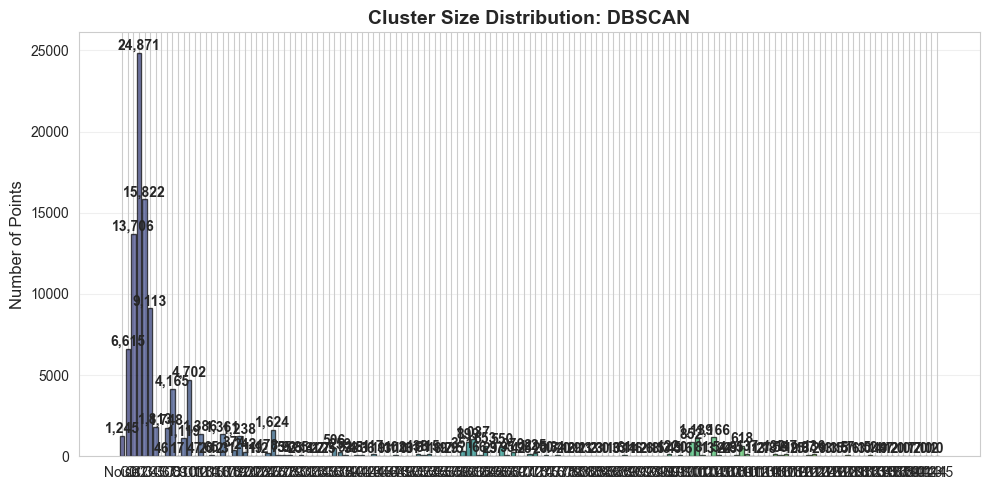


 Quality Metrics:
  Silhouette Score: 0.1805
    → Range: [-1, 1], Higher is better
    → Interpretation: Poor separation

  Davies-Bouldin Score: 0.9125
    → Lower is better (minimum: 0)
    → Interpretation: Good clustering

  Calinski-Harabasz Score: 4022.26
    → Higher is better
    → Interpretation: Excellent clustering


In [10]:
## 6.2 DBSCAN Clustering

def train_dbscan(X_scaled, eps=0.15, min_samples=10):
    """
    Train DBSCAN clustering.
    
    Parameters:
    -----------
    X_scaled : array
        Scaled features
    eps : float
        Maximum distance between two samples
    min_samples : int
        Minimum samples in a neighborhood
    
    Returns:
    --------
    dbscan : DBSCAN
        Fitted DBSCAN model
    labels : array
        Cluster labels
    """
    
    print(f"\n Training DBSCAN...")
    print(f"   eps: {eps}")
    print(f"   min_samples: {min_samples}")
    
    start_time = time()
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    labels = dbscan.fit_predict(X_scaled)
    train_time = time() - start_time
    
    print(f" DBSCAN training complete in {train_time:.2f} seconds")
    
    return dbscan, labels

# Train DBSCAN
dbscan_model, dbscan_labels = train_dbscan(X_scaled, eps=0.15, min_samples=10)

# Evaluate DBSCAN
dbscan_metrics = evaluate_clustering(X_scaled, dbscan_labels, "DBSCAN")


## 7. Visualizations

GENERATING PCA VISUALIZATIONS


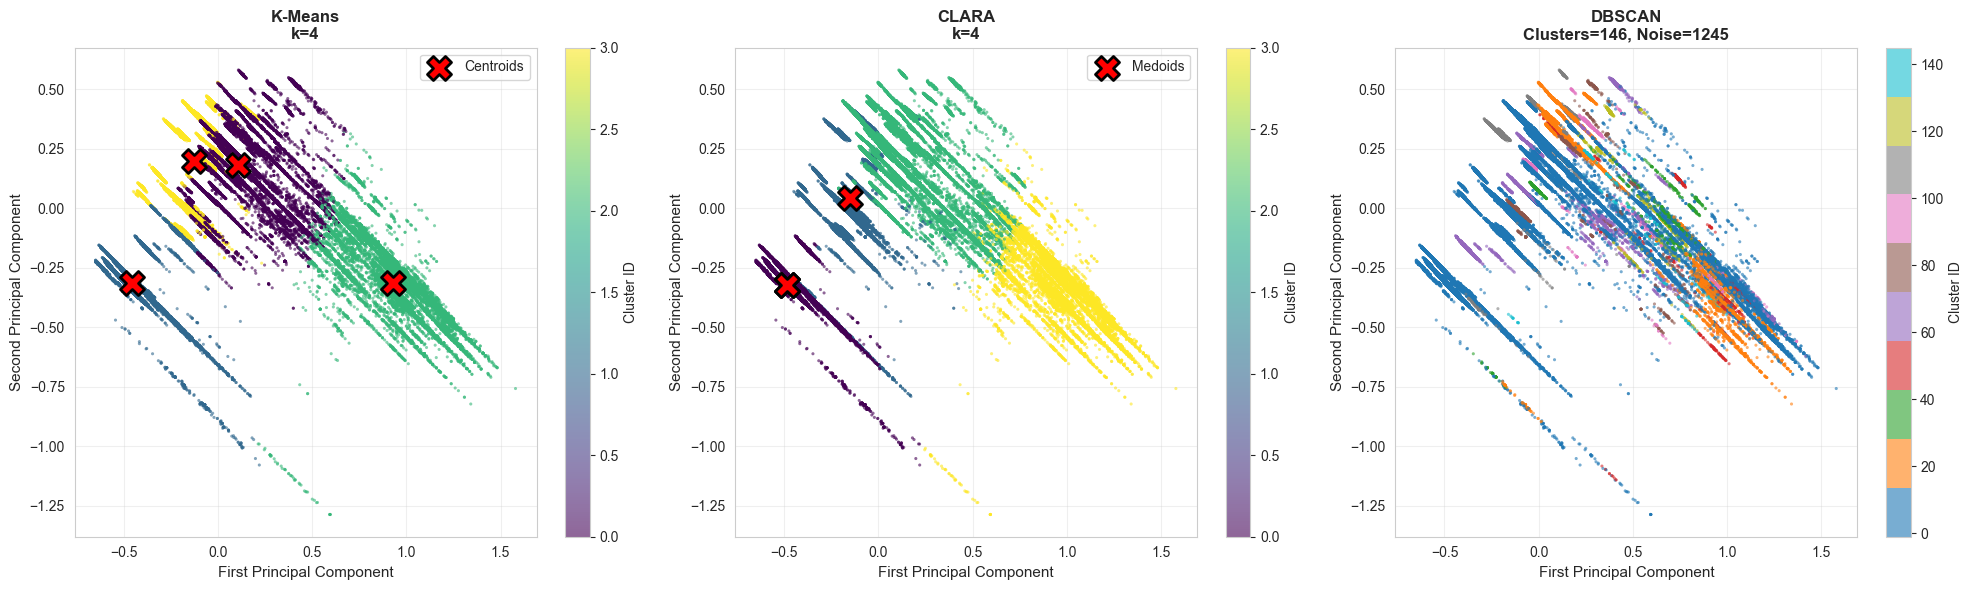

 PCA visualization saved: ../outputs/clustering_pca_comparison.png


In [11]:

## 7.1 PCA Space Visualization

def plot_clusters_pca(X_pca, labels_dict, pca, X_scaled, models_dict):
    """
    Visualize all clustering results in PCA space.
    
    Parameters:
    -----------
    X_pca : array
        PCA-transformed data
    labels_dict : dict
        Dictionary of labels for each method
    pca : PCA
        Fitted PCA object
    X_scaled : array
        Scaled features
    models_dict : dict
        Dictionary of fitted models
    """
    
    print("="*70)
    print("GENERATING PCA VISUALIZATIONS")
    print("="*70)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    methods = ['K-Means', 'CLARA', 'DBSCAN']
    models = [models_dict['kmeans'], models_dict['clara'], models_dict['dbscan']]
    
    for idx, (method, labels, model) in enumerate(zip(methods, labels_dict.values(), models)):
        ax = axes[idx]
        
        # Plot points
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, 
                           cmap='viridis' if method != 'DBSCAN' else 'tab10',
                           s=5, alpha=0.6, edgecolors='none')
        
        # Plot centers/medoids for K-Means and CLARA
        if method == 'K-Means':
            centers_pca = pca.transform(model.cluster_centers_)
            ax.scatter(centers_pca[:, 0], centers_pca[:, 1],
                      c='red', s=300, marker='X', edgecolors='black', 
                      linewidths=2, label='Centroids', zorder=5)
            title_suffix = f"k={len(model.cluster_centers_)}"
        elif method == 'CLARA':
            medoids_pca = pca.transform(X_scaled[model.medoid_indices_])
            ax.scatter(medoids_pca[:, 0], medoids_pca[:, 1],
                      c='red', s=300, marker='X', edgecolors='black',
                      linewidths=2, label='Medoids', zorder=5)
            title_suffix = f"k={len(model.medoid_indices_)}"
        else:  # DBSCAN
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            title_suffix = f"Clusters={n_clusters}, Noise={n_noise}"
        
        ax.set_title(f'{method}\n{title_suffix}', fontsize=12, fontweight='bold')
        ax.set_xlabel('First Principal Component', fontsize=11)
        ax.set_ylabel('Second Principal Component', fontsize=11)
        ax.grid(True, alpha=0.3)
        
        if method in ['K-Means', 'CLARA']:
            ax.legend(loc='upper right')
        
        plt.colorbar(scatter, ax=ax, label='Cluster ID')
    
    plt.tight_layout()
    plt.savefig('../outputs/clustering_pca_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(" PCA visualization saved: ../outputs/clustering_pca_comparison.png")
    print("="*70)

# Create labels dictionary
labels_dict = {
    'K-Means': kmeans_labels,
    'CLARA': clara_labels,
    'DBSCAN': dbscan_labels
}

# Create models dictionary
models_dict = {
    'kmeans': kmeans_model,
    'clara': clara_model,
    'dbscan': dbscan_model
}

# Create output directory
import os
os.makedirs('../outputs', exist_ok=True)

# Plot PCA visualizations
plot_clusters_pca(X_pca, labels_dict, pca, X_scaled, models_dict)


GENERATING GEOGRAPHIC VISUALIZATIONS


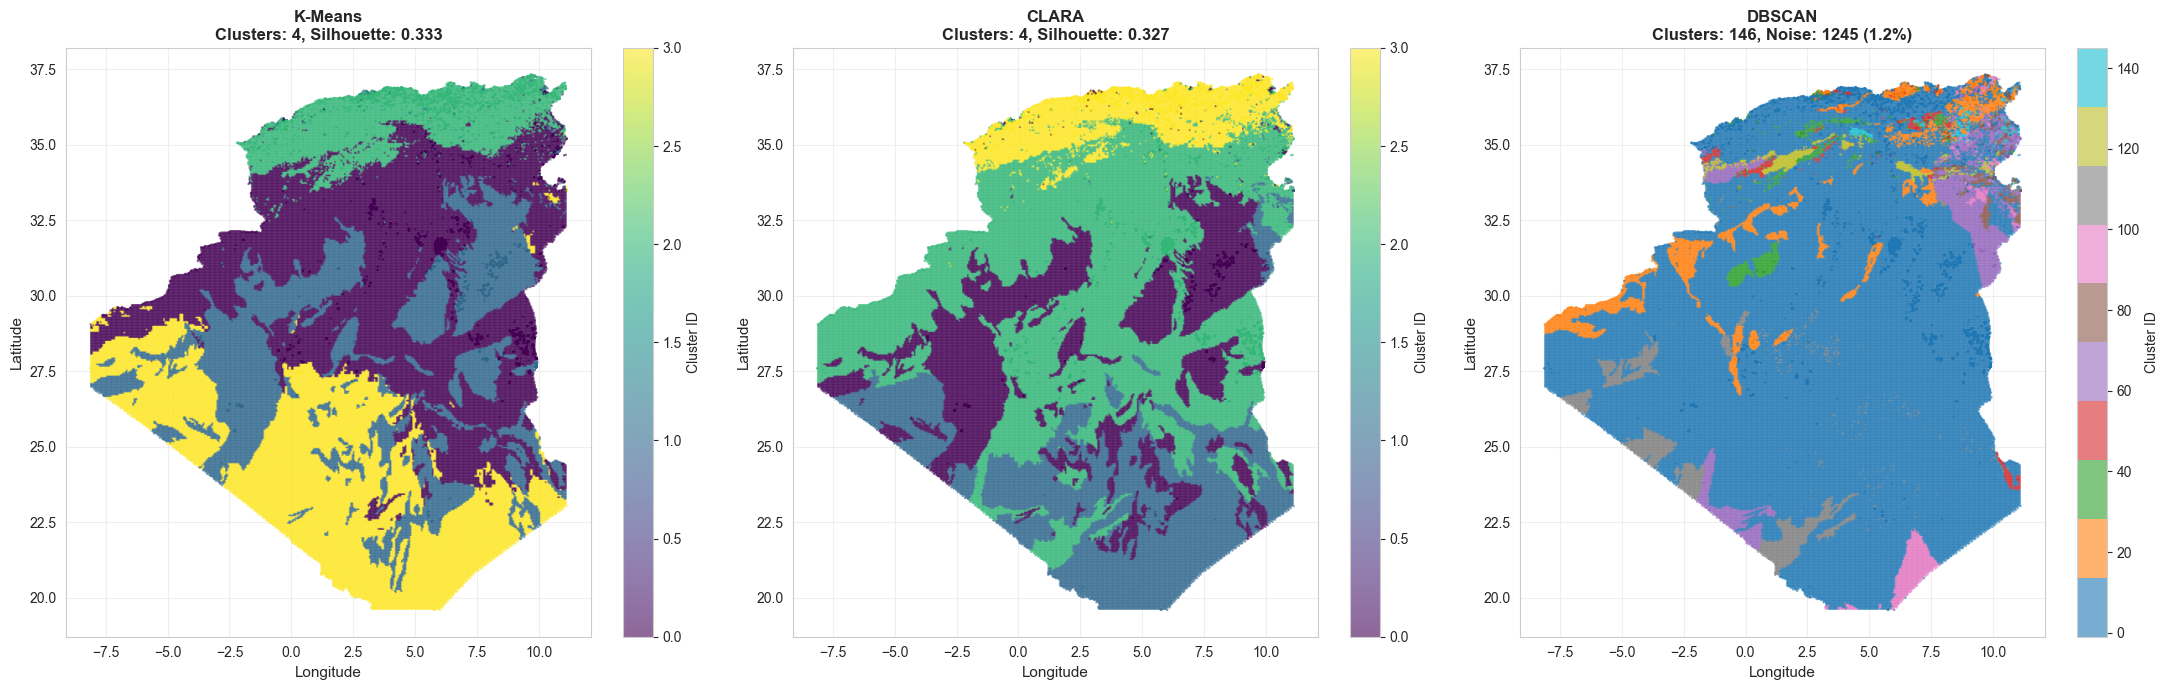

 Geographic visualization saved: ../outputs/clustering_geographic_comparison.png


In [12]:
## 7.2 Geographic Visualization

def plot_clusters_geographic(coords, labels_dict, metrics_dict):
    """
    Visualize clustering results geographically.
    
    Parameters:
    -----------
    coords : array
        Geographic coordinates (latitude, longitude)
    labels_dict : dict
        Dictionary of labels for each method
    metrics_dict : dict
        Dictionary of metrics for each method
    """
    
    if coords is None:
        print("  No geographic coordinates available for mapping")
        return
    
    print("="*70)
    print("GENERATING GEOGRAPHIC VISUALIZATIONS")
    print("="*70)
    
    fig, axes = plt.subplots(1, 3, figsize=(22, 7))
    
    methods = ['K-Means', 'CLARA', 'DBSCAN']
    metrics_list = [metrics_dict['kmeans'], metrics_dict['clara'], metrics_dict['dbscan']]
    
    for idx, (method, labels, metrics) in enumerate(zip(methods, labels_dict.values(), metrics_list)):
        ax = axes[idx]
        
        # Plot points
        scatter = ax.scatter(coords[:, 1], coords[:, 0], c=labels,
                           cmap='viridis' if method != 'DBSCAN' else 'tab10',
                           s=3, alpha=0.6, edgecolors='none')
        
        # Title with metrics
        if method == 'DBSCAN':
            title = f'{method}\nClusters: {metrics["n_clusters"]}, Noise: {metrics["n_noise"]} ({metrics["noise_percentage"]:.1f}%)'
        else:
            title = f'{method}\nClusters: {metrics["n_clusters"]}, Silhouette: {metrics["silhouette"]:.3f}'
        
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('Longitude', fontsize=11)
        ax.set_ylabel('Latitude', fontsize=11)
        ax.grid(True, alpha=0.3)
        
        plt.colorbar(scatter, ax=ax, label='Cluster ID')
    
    plt.tight_layout()
    plt.savefig('../outputs/clustering_geographic_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(" Geographic visualization saved: ../outputs/clustering_geographic_comparison.png")
    print("="*70)

# Create metrics dictionary
metrics_dict = {
    'kmeans': kmeans_metrics,
    'clara': clara_metrics,
    'dbscan': dbscan_metrics
}

# Plot geographic visualizations
plot_clusters_geographic(coords, labels_dict, metrics_dict)


SILHOUETTE ANALYSIS


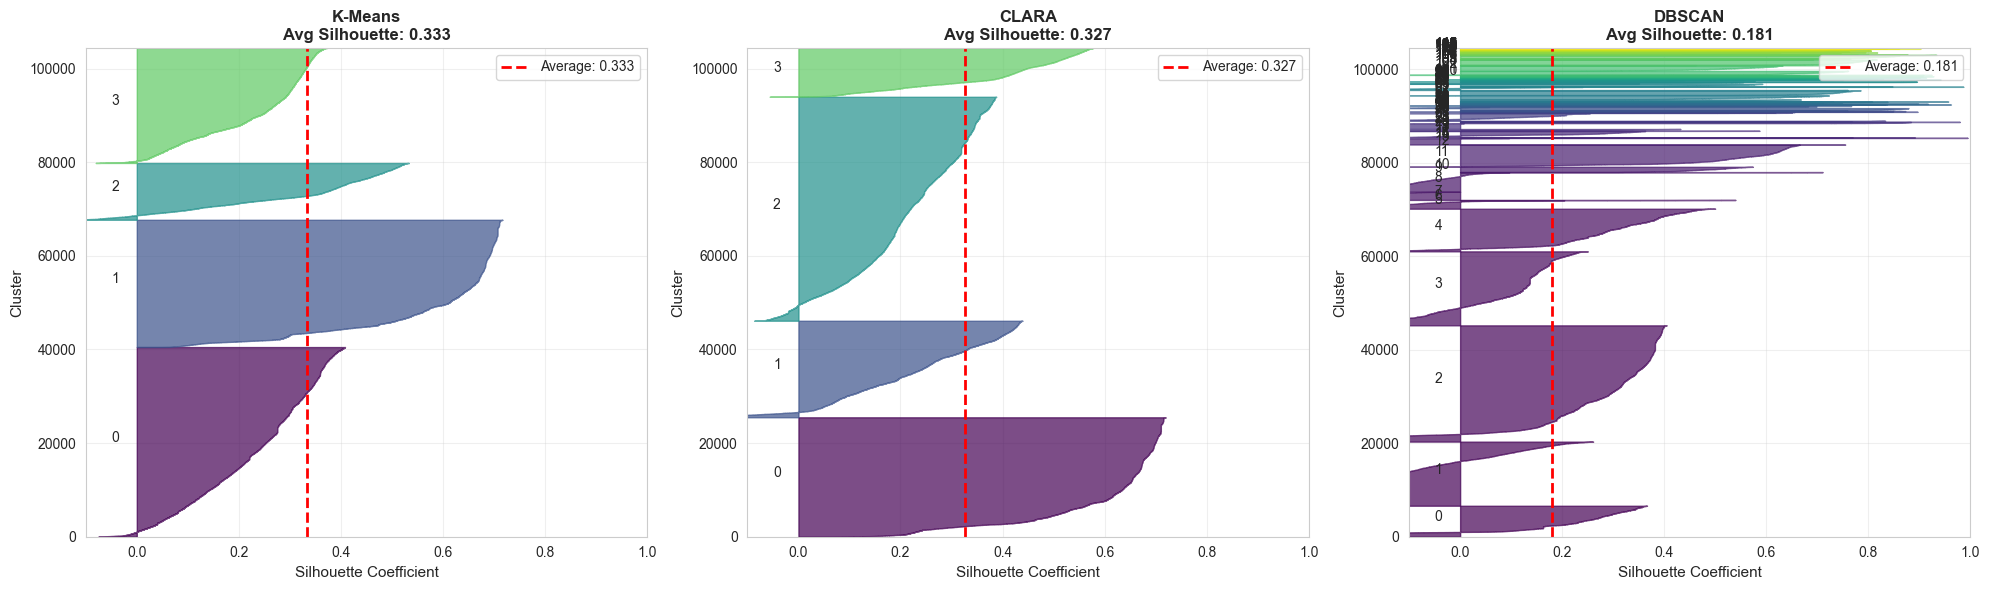

✅ Silhouette analysis saved: ../outputs/silhouette_analysis.png


In [13]:
## 7.3 Silhouette Analysis

def plot_silhouette_analysis(X_scaled, labels_dict):
    """
    Create silhouette plots for all clustering methods.
    
    Parameters:
    -----------
    X_scaled : array
        Scaled features
    labels_dict : dict
        Dictionary of labels for each method
    """
    
    print("="*70)
    print("SILHOUETTE ANALYSIS")
    print("="*70)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    methods = ['K-Means', 'CLARA', 'DBSCAN']
    
    for idx, (method, labels) in enumerate(zip(methods, labels_dict.values())):
        ax = axes[idx]
        
        # Remove noise points for DBSCAN
        if method == 'DBSCAN':
            valid_mask = labels != -1
            labels_clean = labels[valid_mask]
            X_clean = X_scaled[valid_mask]
        else:
            labels_clean = labels
            X_clean = X_scaled
        
        n_clusters = len(set(labels_clean))
        
        if n_clusters < 2:
            ax.text(0.5, 0.5, 'Insufficient clusters\nfor silhouette analysis',
                   ha='center', va='center', fontsize=12)
            ax.set_title(method, fontsize=12, fontweight='bold')
            continue
        
        # Compute silhouette scores
        silhouette_vals = silhouette_samples(X_clean, labels_clean)
        silhouette_avg = silhouette_score(X_clean, labels_clean)
        
        y_lower = 10
        for i in range(n_clusters):
            # Get silhouette values for cluster i
            cluster_silhouette_vals = silhouette_vals[labels_clean == i]
            cluster_silhouette_vals.sort()
            
            size_cluster_i = cluster_silhouette_vals.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = plt.cm.viridis(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                            0, cluster_silhouette_vals,
                            facecolor=color, edgecolor=color, alpha=0.7)
            
            # Label clusters
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        
        ax.set_title(f'{method}\nAvg Silhouette: {silhouette_avg:.3f}',
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Silhouette Coefficient', fontsize=11)
        ax.set_ylabel('Cluster', fontsize=11)
        
        # Average silhouette line
        ax.axvline(x=silhouette_avg, color="red", linestyle="--", 
                  linewidth=2, label=f'Average: {silhouette_avg:.3f}')
        ax.set_xlim([-0.1, 1])
        ax.set_ylim([0, len(labels_clean) + (n_clusters + 1) * 10])
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/silhouette_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Silhouette analysis saved: ../outputs/silhouette_analysis.png")
    print("="*70)

# Plot silhouette analysis
plot_silhouette_analysis(X_scaled, labels_dict)


CLUSTER PROFILING: K-MEANS

Analyzing 4 clusters...

 Cluster Summary:
 Cluster  Size    Size %  elevation  tmax_winter  tmax_summer  tmin_winter  prec_winter  prec_spring  prec_summer    COARSE      SILT  REF_BULK
       0 40502 38.805427 507.043998    19.742640    41.250562     5.775014     4.339792     4.645650     1.753225 11.798860 27.829801  1.647966
       1 27175 26.036677 445.968611    21.861935    42.830435     6.829599     2.331545     2.789671     1.080538 -3.062226 -3.036357  1.549398
       2 12125 11.617100 641.636041    14.590110    33.757180     4.964064    47.344196    22.856145     6.132029 11.332916 32.773460  1.764888
       3 24570 23.540796 484.333496    24.950577    42.122850     8.853371     0.852985     0.835494     2.795599 12.269627 20.417189  1.620973


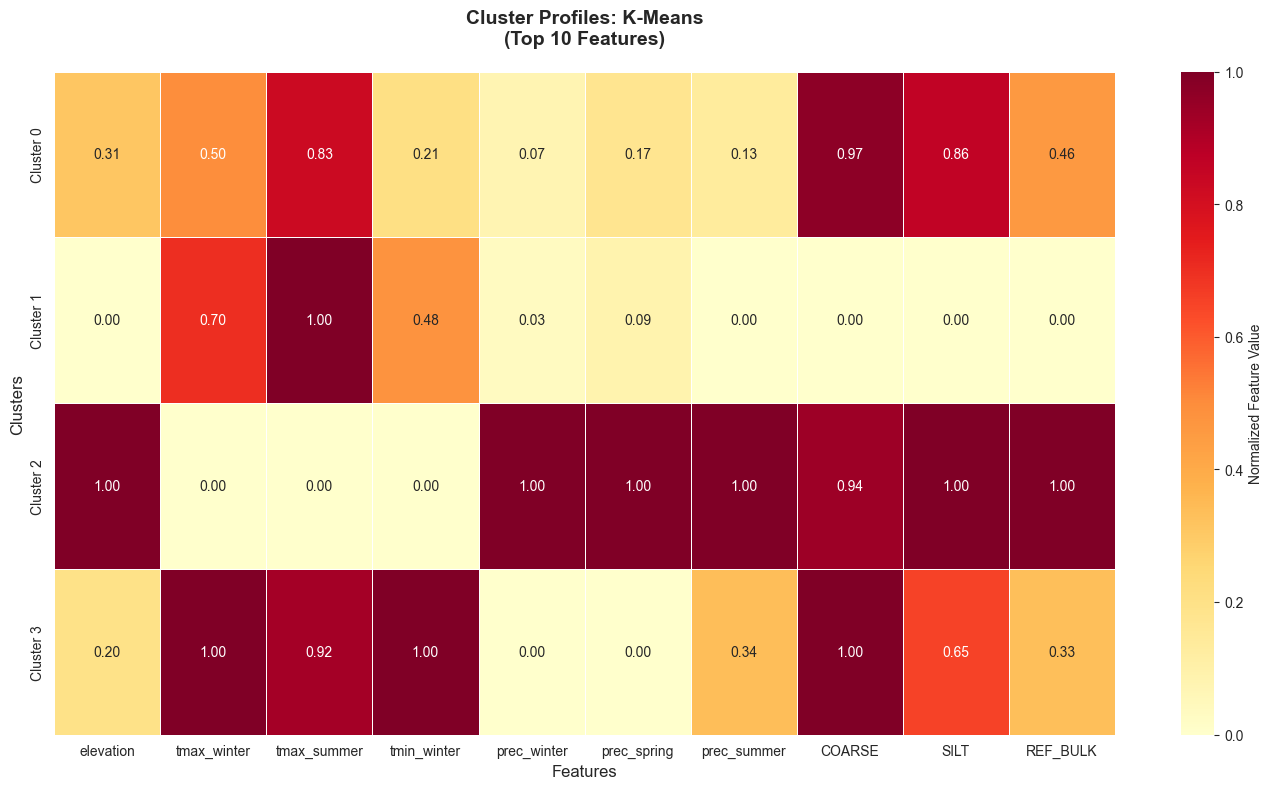


 Cluster profiling complete for K-Means
CLUSTER PROFILING: CLARA

Analyzing 4 clusters...

 Cluster Summary:
 Cluster  Size    Size %  elevation  tmax_winter  tmax_summer  tmin_winter  prec_winter  prec_spring  prec_summer    COARSE      SILT  REF_BULK
       0 25498 24.429924 410.631265    21.867482    43.127195     6.874522     2.355600     2.788063     0.923936 -3.485371 -3.523884  1.549325
       1 20612 19.748592 622.648894    24.402231    40.822110     8.218988     1.086735     1.524219     3.249546 11.033793 15.789277  1.594669
       2 47833 45.829341 475.298580    20.282608    41.556767     6.247424     4.450409     4.348187     1.893700 12.073634 28.475828  1.655265
       3 10429  9.992143 603.713875    14.663095    33.564502     5.147303    51.663336    24.080179     5.972960 11.262928 33.176457  1.776499


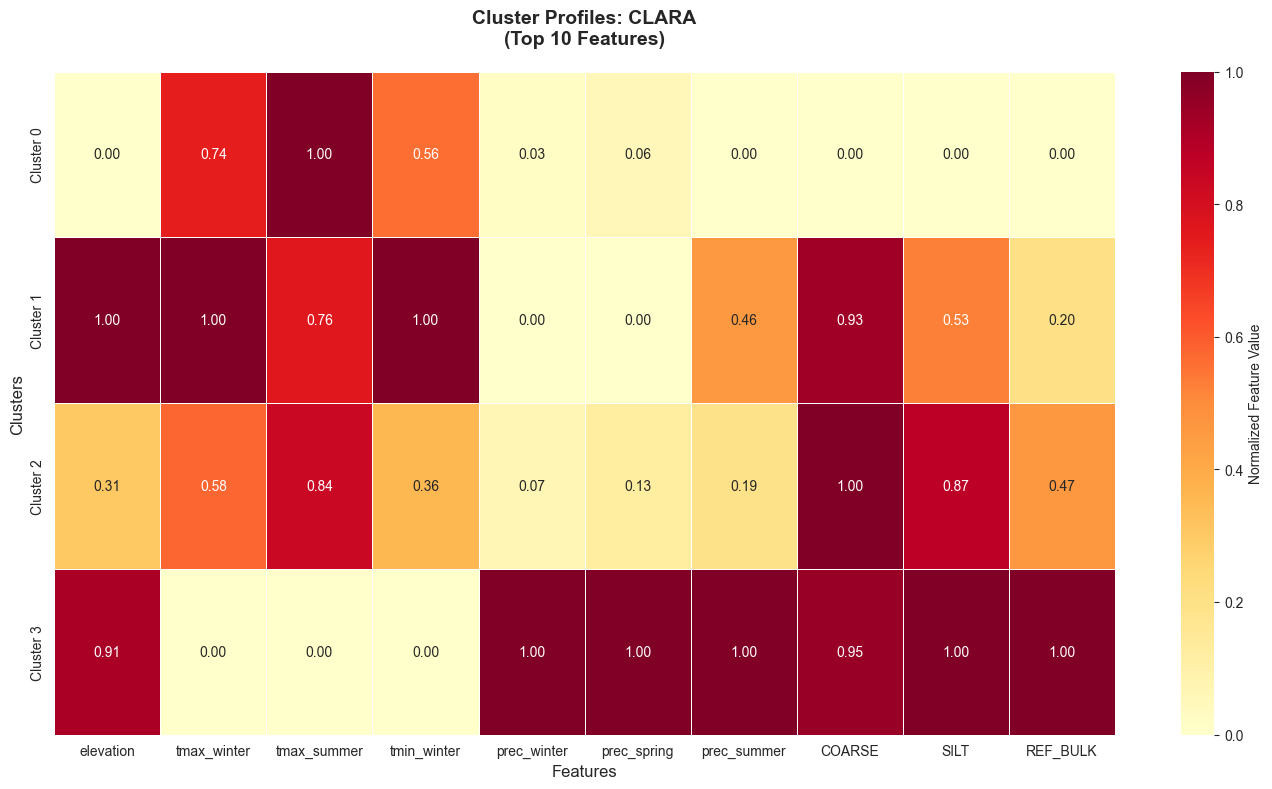


 Cluster profiling complete for CLARA
CLUSTER PROFILING: DBSCAN

Analyzing 146 clusters...

 Cluster Summary:
 Cluster  Size    Size %   elevation  tmax_winter  tmax_summer  tmin_winter  prec_winter  prec_spring  prec_summer    COARSE      SILT  REF_BULK
       0  6615  6.337907  544.900983    20.787541    41.171794     5.867246     3.249456     4.290625     0.941339 12.561476 26.645654  1.639536
       1 13706 13.131874  696.835911    24.203931    40.530443     7.722980     0.949356     1.504072     3.294372  9.939771 12.886339  1.584119
       2 24871 23.829188  438.410599    22.019440    43.094498     6.870287     1.816363     2.353973     1.080230 -3.799526 -3.799526  1.560000
       3 15822 15.159238  485.859752    19.690289    41.748531     6.062977     3.852457     3.743726     1.891359 14.523584 27.624116  1.622708
       4  9113  8.731269  341.546253    23.897043    43.878790     8.296509     0.876923     0.690390     1.221200 15.301438 25.734445  1.674091
       5  1813  1.7

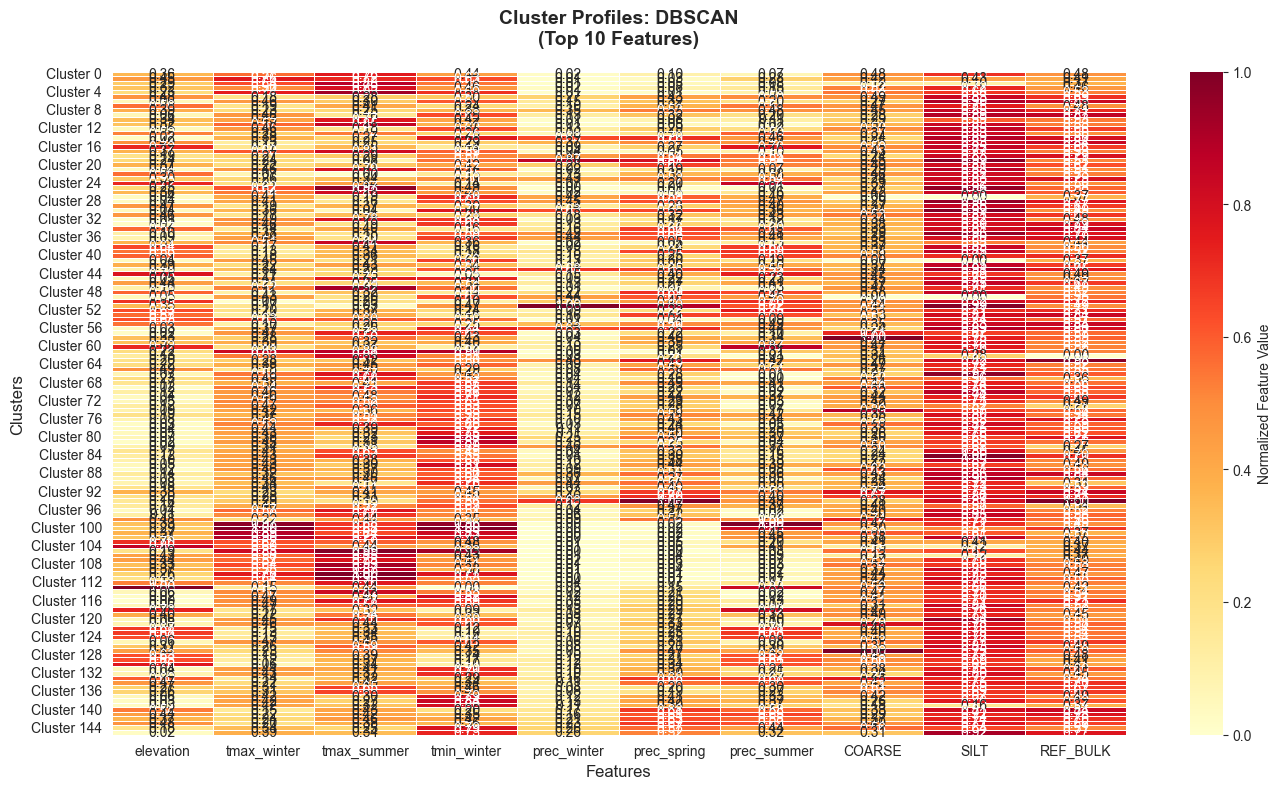


 Cluster profiling complete for DBSCAN


In [14]:
## 8. Cluster Profiling

def profile_clusters(df, labels, feature_names, method_name, top_features=10):
    """
    Profile clusters by analyzing feature distributions.
    
    Parameters:
    -----------
    df : DataFrame
        Original dataframe
    labels : array
        Cluster labels
    feature_names : list
        Feature names
    method_name : str
        Clustering method name
    top_features : int
        Number of top features to display
    """
    
    print("="*70)
    print(f"CLUSTER PROFILING: {method_name.upper()}")
    print("="*70)
    
    # Add cluster labels to dataframe
    df_temp = df.copy()
    df_temp['cluster'] = labels
    
    # Get unique clusters (excluding noise)
    unique_clusters = sorted([c for c in df_temp['cluster'].unique() if c != -1])
    
    print(f"\nAnalyzing {len(unique_clusters)} clusters...")
    
    # Compute cluster statistics
    cluster_profiles = []
    
    for cluster_id in unique_clusters:
        cluster_data = df_temp[df_temp['cluster'] == cluster_id][feature_names]
        
        profile = {
            'Cluster': cluster_id,
            'Size': len(cluster_data),
            'Size %': len(cluster_data) / len(df_temp) * 100
        }
        
        # Add mean values for top features
        for feat in feature_names[:top_features]:
            if feat in cluster_data.columns:
                profile[feat] = cluster_data[feat].mean()
        
        cluster_profiles.append(profile)
    
    # Create summary dataframe
    profile_df = pd.DataFrame(cluster_profiles)
    
    print("\n Cluster Summary:")
    print(profile_df.to_string(index=False))
    
    # Visualize cluster characteristics
    if len(unique_clusters) > 1 and len(feature_names) >= top_features:
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Select top features for visualization
        features_to_plot = feature_names[:top_features]
        
        # Prepare data for heatmap
        heatmap_data = []
        for cluster_id in unique_clusters:
            cluster_data = df_temp[df_temp['cluster'] == cluster_id][features_to_plot]
            heatmap_data.append(cluster_data.mean().values)
        
        heatmap_df = pd.DataFrame(heatmap_data, 
                                  index=[f'Cluster {c}' for c in unique_clusters],
                                  columns=features_to_plot)
        
        # Normalize for better visualization
        heatmap_normalized = (heatmap_df - heatmap_df.min()) / (heatmap_df.max() - heatmap_df.min())
        
        sns.heatmap(heatmap_normalized, annot=True, fmt='.2f', cmap='YlOrRd',
                   cbar_kws={'label': 'Normalized Feature Value'},
                   linewidths=0.5, ax=ax)
        
        ax.set_title(f'Cluster Profiles: {method_name}\n(Top {top_features} Features)',
                    fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel('Features', fontsize=12)
        ax.set_ylabel('Clusters', fontsize=12)
        
        plt.tight_layout()
        plt.savefig(f'../outputs/cluster_profile_{method_name.lower().replace(" ", "_")}.png',
                   dpi=300, bbox_inches='tight')
        plt.show()
    
    print(f"\n Cluster profiling complete for {method_name}")
    print("="*70)
    
    return profile_df

# Profile clusters for each method
kmeans_profile = profile_clusters(df, kmeans_labels, feature_names, "K-Means", top_features=10)
clara_profile = profile_clusters(df, clara_labels, feature_names, "CLARA", top_features=10)
dbscan_profile = profile_clusters(df, dbscan_labels, feature_names, "DBSCAN", top_features=10)



## 9. Fire Risk Analysis by Cluster

FIRE RISK ANALYSIS: K-MEANS

🔥 Fire Risk by Cluster:
 Cluster  Total Points  Fire Points  Fire Rate (%) Risk Level
       0         40502         7421      18.322552       High
       1         27175         4105      15.105796       High
       2         12125         2516      20.750515       High
       3         24570          174       0.708181        Low


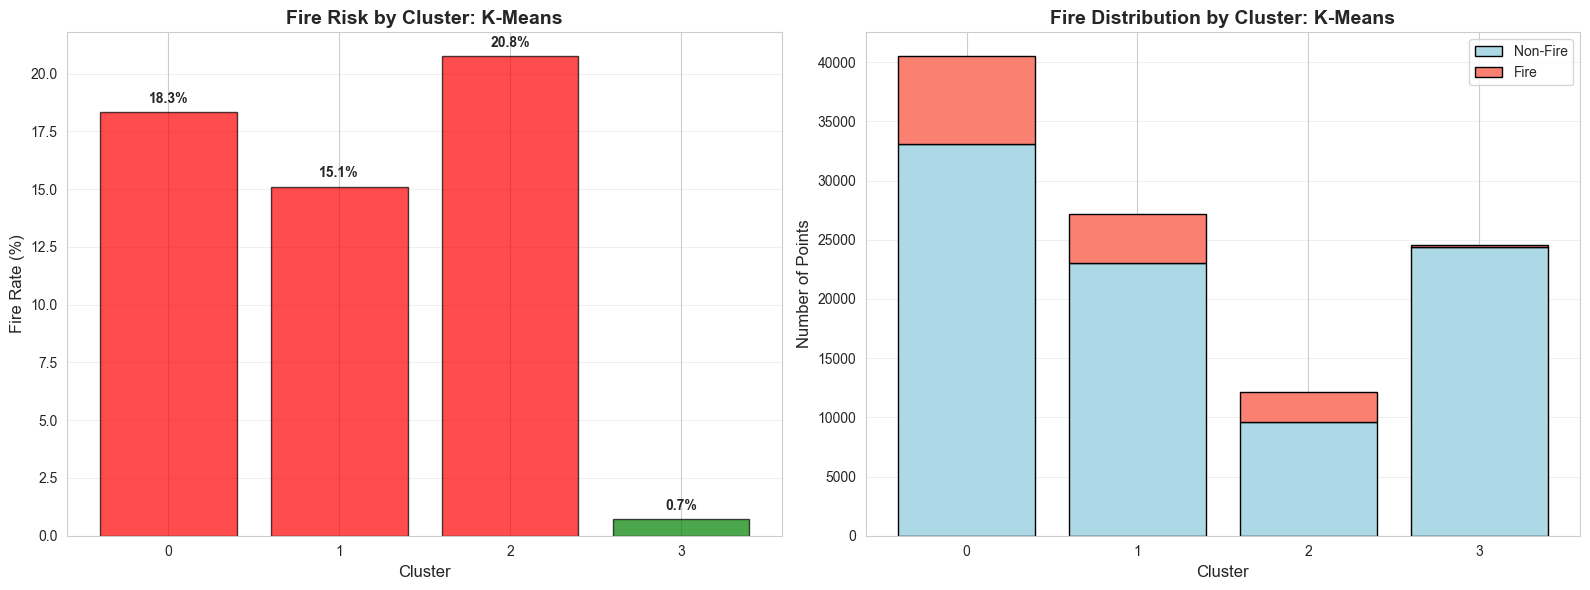


 Fire risk analysis complete for K-Means
FIRE RISK ANALYSIS: CLARA

🔥 Fire Risk by Cluster:
 Cluster  Total Points  Fire Points  Fire Rate (%) Risk Level
       0         25498         4085      16.020864       High
       1         20612          162       0.785950        Low
       2         47833         7600      15.888612       High
       3         10429         2369      22.715505       High


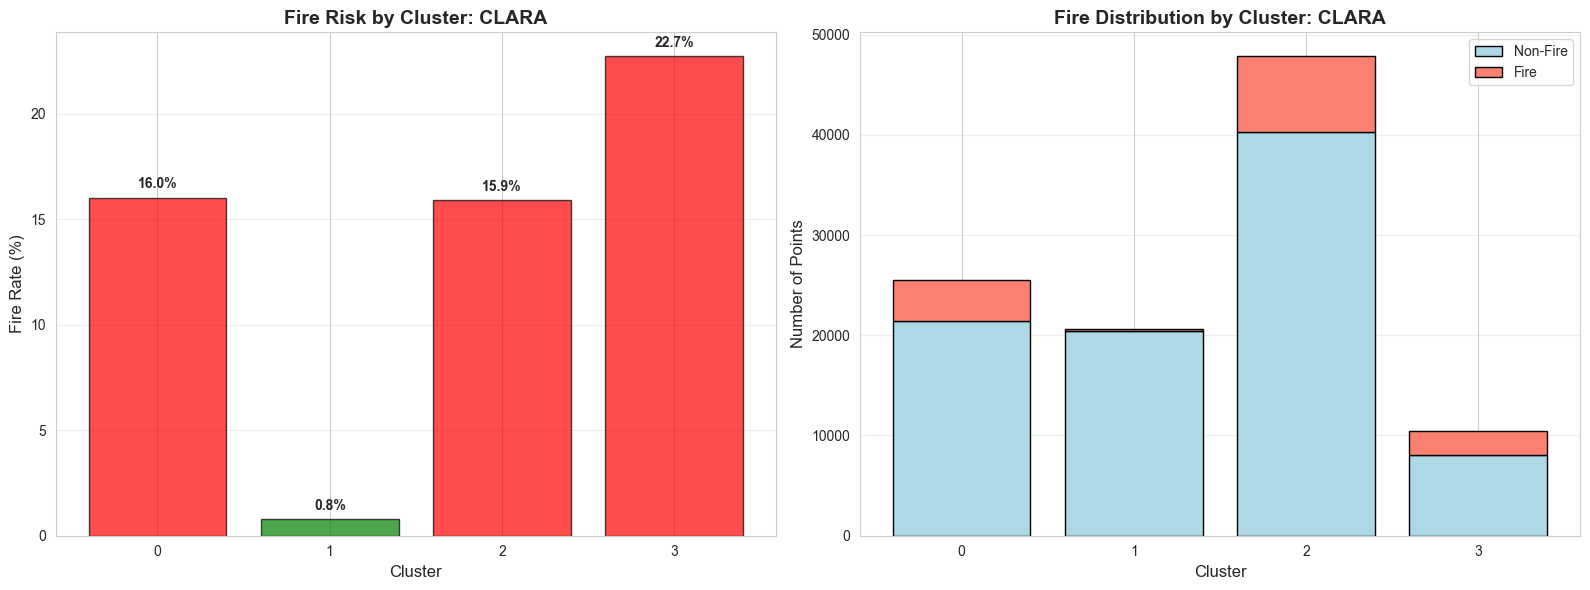


 Fire risk analysis complete for CLARA
FIRE RISK ANALYSIS: DBSCAN

🔥 Fire Risk by Cluster:
 Cluster  Total Points  Fire Points  Fire Rate (%) Risk Level
       0          6615         1599      24.172336       High
       1         13706          425       3.100832        Low
       2         24871         3917      15.749266       High
       3         15822         3540      22.373910       High
       4          9113          566       6.210907     Medium
       5          1813          264      14.561500       High
       6            46           22      47.826087       High
       7          1748           85       4.862700        Low
       8          4165         1087      26.098439       High
       9            17           11      64.705882       High
      10          1119          145      12.957998       High
      11          4702          554      11.782220       High
      12            47           35      74.468085       High
      13          1386           36     

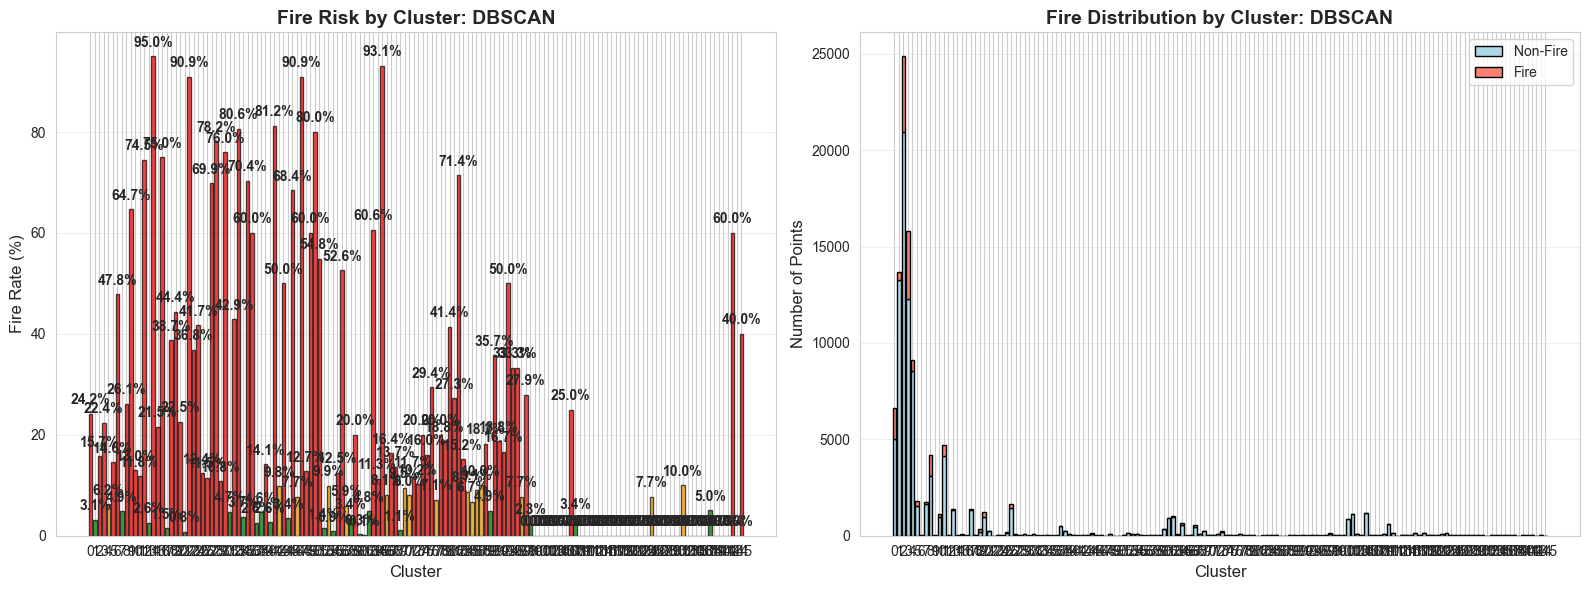


 Fire risk analysis complete for DBSCAN


In [15]:

def analyze_fire_risk_by_cluster(df, labels, method_name):
    """
    Analyze fire occurrence patterns within each cluster.
    
    Parameters:
    -----------
    df : DataFrame
        Original dataframe with fire labels
    labels : array
        Cluster labels
    method_name : str
        Clustering method name
    """
    
    if 'fire' not in df.columns:
        print("  Fire labels not available for risk analysis")
        return
    
    print("="*70)
    print(f"FIRE RISK ANALYSIS: {method_name.upper()}")
    print("="*70)
    
    df_temp = df.copy()
    df_temp['cluster'] = labels
    
    # Calculate fire risk per cluster
    unique_clusters = sorted([c for c in df_temp['cluster'].unique() if c != -1])
    
    risk_data = []
    for cluster_id in unique_clusters:
        cluster_data = df_temp[df_temp['cluster'] == cluster_id]
        
        total = len(cluster_data)
        fires = cluster_data['fire'].sum()
        fire_rate = (fires / total * 100) if total > 0 else 0
        
        risk_data.append({
            'Cluster': cluster_id,
            'Total Points': total,
            'Fire Points': fires,
            'Fire Rate (%)': fire_rate,
            'Risk Level': 'High' if fire_rate > 10 else 'Medium' if fire_rate > 5 else 'Low'
        })
    
    risk_df = pd.DataFrame(risk_data)
    
    print("\n🔥 Fire Risk by Cluster:")
    print(risk_df.to_string(index=False))
    
    # Visualize fire risk
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot - Fire rate
    colors = ['red' if rate > 10 else 'orange' if rate > 5 else 'green' 
             for rate in risk_df['Fire Rate (%)']]
    
    axes[0].bar(risk_df['Cluster'].astype(str), risk_df['Fire Rate (%)'],
               color=colors, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Cluster', fontsize=12)
    axes[0].set_ylabel('Fire Rate (%)', fontsize=12)
    axes[0].set_title(f'Fire Risk by Cluster: {method_name}',
                     fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (cluster, rate) in enumerate(zip(risk_df['Cluster'], risk_df['Fire Rate (%)'])):
        axes[0].text(i, rate + max(risk_df['Fire Rate (%)'])*0.02,
                    f'{rate:.1f}%', ha='center', fontweight='bold')
    
    # Stacked bar - Fire vs Non-Fire
    non_fire = risk_df['Total Points'] - risk_df['Fire Points']
    x = np.arange(len(risk_df))
    
    axes[1].bar(x, non_fire, label='Non-Fire', color='lightblue', edgecolor='black')
    axes[1].bar(x, risk_df['Fire Points'], bottom=non_fire, 
               label='Fire', color='salmon', edgecolor='black')
    
    axes[1].set_xlabel('Cluster', fontsize=12)
    axes[1].set_ylabel('Number of Points', fontsize=12)
    axes[1].set_title(f'Fire Distribution by Cluster: {method_name}',
                     fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(risk_df['Cluster'].astype(str))
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'../outputs/fire_risk_{method_name.lower().replace(" ", "_")}.png',
               dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n Fire risk analysis complete for {method_name}")
    print("="*70)
    
    return risk_df

# Analyze fire risk for each method
kmeans_risk = analyze_fire_risk_by_cluster(df, kmeans_labels, "K-Means")
clara_risk = analyze_fire_risk_by_cluster(df, clara_labels, "CLARA")
dbscan_risk = analyze_fire_risk_by_cluster(df, dbscan_labels, "DBSCAN")


## 10. Comparative Analysis

CLUSTERING METHODS COMPARISON

 Performance Comparison:
Method  N Clusters  Noise Points Noise %  Silhouette  Davies-Bouldin  Calinski-Harabasz
KMEANS           4             0   0.00%    0.333125        1.273106       60167.072516
 CLARA           4             0   0.00%    0.326825        1.266681       57272.662511
DBSCAN         146          1245   1.19%    0.180523        0.912534        4022.260507


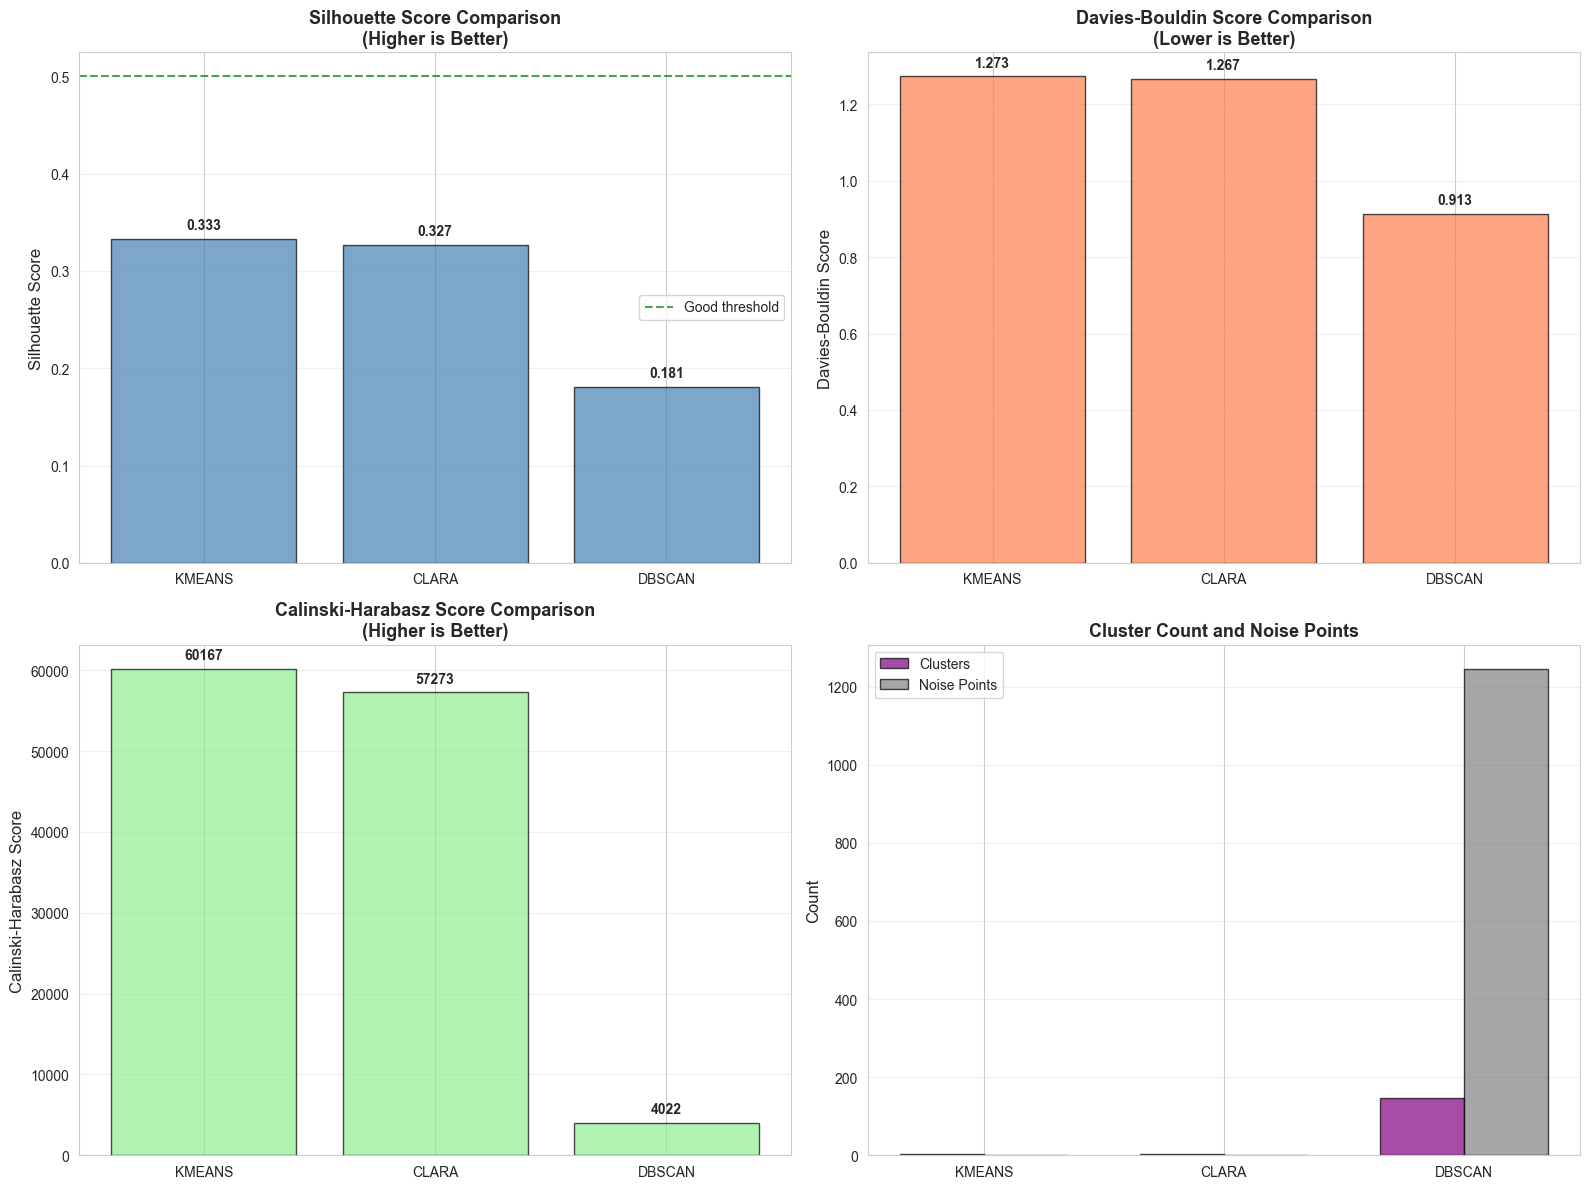


 BEST METHOD BY METRIC:
  • Best Silhouette: KMEANS (0.3331)
  • Best Davies-Bouldin: DBSCAN (0.9125)
  • Best Calinski-Harabasz: KMEANS (60167.07)

 Comparison visualization saved: ../outputs/clustering_comparison.png


In [16]:

def compare_clustering_methods(metrics_dict):
    """
    Comprehensive comparison of all clustering methods.
    
    Parameters:
    -----------
    metrics_dict : dict
        Dictionary of metrics for each method
    """
    
    print("="*70)
    print("CLUSTERING METHODS COMPARISON")
    print("="*70)
    
    # Create comparison dataframe
    comparison_data = []
    for method, metrics in metrics_dict.items():
        comparison_data.append({
            'Method': method.upper(),
            'N Clusters': metrics['n_clusters'],
            'Noise Points': metrics['n_noise'],
            'Noise %': f"{metrics['noise_percentage']:.2f}%",
            'Silhouette': metrics.get('silhouette', np.nan),
            'Davies-Bouldin': metrics.get('davies_bouldin', np.nan),
            'Calinski-Harabasz': metrics.get('calinski_harabasz', np.nan)
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n Performance Comparison:")
    print(comparison_df.to_string(index=False))
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    methods = comparison_df['Method'].values
    
    # Plot 1: Silhouette Score
    silhouette_vals = comparison_df['Silhouette'].values
    valid_sil = ~np.isnan(silhouette_vals)
    if valid_sil.any():
        axes[0, 0].bar(methods[valid_sil], silhouette_vals[valid_sil],
                      color='steelblue', edgecolor='black', alpha=0.7)
        axes[0, 0].set_ylabel('Silhouette Score', fontsize=12)
        axes[0, 0].set_title('Silhouette Score Comparison\n(Higher is Better)',
                            fontsize=13, fontweight='bold')
        axes[0, 0].grid(axis='y', alpha=0.3)
        axes[0, 0].axhline(y=0.5, color='green', linestyle='--', 
                          label='Good threshold', alpha=0.7)
        axes[0, 0].legend()
        
        for i, (method, val) in enumerate(zip(methods[valid_sil], silhouette_vals[valid_sil])):
            axes[0, 0].text(i, val + 0.01, f'{val:.3f}',
                           ha='center', fontweight='bold')
    
    # Plot 2: Davies-Bouldin Score
    db_vals = comparison_df['Davies-Bouldin'].values
    valid_db = ~np.isnan(db_vals)
    if valid_db.any():
        axes[0, 1].bar(methods[valid_db], db_vals[valid_db],
                      color='coral', edgecolor='black', alpha=0.7)
        axes[0, 1].set_ylabel('Davies-Bouldin Score', fontsize=12)
        axes[0, 1].set_title('Davies-Bouldin Score Comparison\n(Lower is Better)',
                            fontsize=13, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
        
        for i, (method, val) in enumerate(zip(methods[valid_db], db_vals[valid_db])):
            axes[0, 1].text(i, val + max(db_vals[valid_db])*0.02, f'{val:.3f}',
                           ha='center', fontweight='bold')
    
    # Plot 3: Calinski-Harabasz Score
    ch_vals = comparison_df['Calinski-Harabasz'].values
    valid_ch = ~np.isnan(ch_vals)
    if valid_ch.any():
        axes[1, 0].bar(methods[valid_ch], ch_vals[valid_ch],
                      color='lightgreen', edgecolor='black', alpha=0.7)
        axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=12)
        axes[1, 0].set_title('Calinski-Harabasz Score Comparison\n(Higher is Better)',
                            fontsize=13, fontweight='bold')
        axes[1, 0].grid(axis='y', alpha=0.3)
        
        for i, (method, val) in enumerate(zip(methods[valid_ch], ch_vals[valid_ch])):
            axes[1, 0].text(i, val + max(ch_vals[valid_ch])*0.02, f'{val:.0f}',
                           ha='center', fontweight='bold')
    
    # Plot 4: Cluster Count and Noise
    x = np.arange(len(methods))
    width = 0.35
    
    axes[1, 1].bar(x - width/2, comparison_df['N Clusters'], width,
                  label='Clusters', color='purple', edgecolor='black', alpha=0.7)
    axes[1, 1].bar(x + width/2, comparison_df['Noise Points'], width,
                  label='Noise Points', color='gray', edgecolor='black', alpha=0.7)
    
    axes[1, 1].set_ylabel('Count', fontsize=12)
    axes[1, 1].set_title('Cluster Count and Noise Points',
                        fontsize=13, fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(methods)
    axes[1, 1].legend()
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/clustering_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Determine best method
    print("\n BEST METHOD BY METRIC:")
    
    if valid_sil.any():
        best_sil_idx = np.nanargmax(silhouette_vals)
        print(f"  • Best Silhouette: {methods[best_sil_idx]} ({silhouette_vals[best_sil_idx]:.4f})")
    
    if valid_db.any():
        best_db_idx = np.nanargmin(db_vals)
        print(f"  • Best Davies-Bouldin: {methods[best_db_idx]} ({db_vals[best_db_idx]:.4f})")
    
    if valid_ch.any():
        best_ch_idx = np.nanargmax(ch_vals)
        print(f"  • Best Calinski-Harabasz: {methods[best_ch_idx]} ({ch_vals[best_ch_idx]:.2f})")
    
    print("\n Comparison visualization saved: ../outputs/clustering_comparison.png")
    print("="*70)
    
    return comparison_df

# Compare all methods
comparison_summary = compare_clustering_methods(metrics_dict)


In [17]:

## 11. Save Results
def save_clustering_results(df, labels_dict, comparison_summary):
    """
    Save clustering results to files.
    
    Parameters:
    -----------
    df : DataFrame
        Original dataframe
    labels_dict : dict
        Dictionary of cluster labels
    comparison_summary : DataFrame
        Comparison metrics
    """
    
    print("="*70)
    print("SAVING CLUSTERING RESULTS")
    print("="*70)
    
    # Add cluster labels to dataframe
    df_labeled = df.copy()
    df_labeled['kmeans_cluster'] = labels_dict['K-Means']
    df_labeled['clara_cluster'] = labels_dict['CLARA']
    df_labeled['dbscan_cluster'] = labels_dict['DBSCAN']
    
    # Save labeled dataset
    output_path = '../data/processed/Fire/fnf_with_clusters.csv'
    df_labeled.to_csv(output_path, index=False)
    print(f" Labeled dataset saved: {output_path}")
    
    # Save comparison metrics
    metrics_path = '../outputs/clustering_metrics_summary.csv'
    comparison_summary.to_csv(metrics_path, index=False)
    print(f" Metrics summary saved: {metrics_path}")
    
    # Save cluster statistics
    stats_path = '../outputs/clustering_statistics.txt'
    with open(stats_path, 'w') as f:
        f.write("CLUSTERING ANALYSIS SUMMARY\n")
        f.write("="*70 + "\n\n")
        
        for method, labels in labels_dict.items():
            f.write(f"{method}:\n")
            f.write("-"*40 + "\n")
            unique, counts = np.unique(labels, return_counts=True)
            for cluster_id, count in zip(unique, counts):
                label_str = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
                f.write(f"  {label_str}: {count:,} ({count/len(labels)*100:.2f}%)\n")
            f.write("\n")
    
    print(f" Statistics saved: {stats_path}")
    
    print("\n Output Files:")
    print(f"  • {output_path}")
    print(f"  • {metrics_path}")
    print(f"  • {stats_path}")
    print(f"  • ../outputs/clustering_*.png (visualizations)")
    
    print("="*70)

# Save all results
save_clustering_results(df, labels_dict, comparison_summary)


SAVING CLUSTERING RESULTS
 Labeled dataset saved: ../data/processed/Fire/fnf_with_clusters.csv
 Metrics summary saved: ../outputs/clustering_metrics_summary.csv
 Statistics saved: ../outputs/clustering_statistics.txt

 Output Files:
  • ../data/processed/Fire/fnf_with_clusters.csv
  • ../outputs/clustering_metrics_summary.csv
  • ../outputs/clustering_statistics.txt
  • ../outputs/clustering_*.png (visualizations)
